
# Audio Data Augmentation

**Author**: [Moto Hira](moto@meta.com)_

``torchaudio`` provides a variety of ways to augment audio data.

In this tutorial, we look into a way to apply effects, filters,
RIR (room impulse response) and codecs.

At the end, we synthesize noisy speech over phone from clean speech.


In [82]:
import torch
import torchaudio
import torchaudio.functional as F

print(torch.__version__)
print(torchaudio.__version__)

import os
import random

1.13.1+cu117
0.13.1+cu117


## Preparation

First, we import the modules and download the audio assets we use in this tutorial.




In [50]:
import math

from IPython.display import Audio
import matplotlib.pyplot as plt

from torchaudio.utils import download_asset

SAMPLE_WAV = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.wav")
SAMPLE_RIR = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo-8000hz.wav")
SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav")
SAMPLE_NOISE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo-8000hz.wav")

In [92]:
print(os.getcwd())
print(os.listdir("../../../datasets/GTZAN/gtzan_genre/genres/blues"))

/home/oriol_colome_font_epidemicsound_/Master-Thesis-1/utils/positive generator/torchaudio tutorials
['blues.00052.wav', 'blues.00092.wav', 'blues.00093.wav', 'blues.00070.wav', 'blues.00076.wav', 'blues.00058.wav', 'blues.00098.wav', 'blues.00073.wav', 'blues.00038.wav', 'blues.00034.wav', 'blues.00069.wav', 'blues.00064.wav', 'blues.00057.wav', 'blues.00097.wav', 'blues.00007.wav', 'blues.00040.wav', 'blues.00049.wav', 'blues.00000.wav', 'blues.00027.wav', 'blues.00077.wav', 'blues.00075.wav', 'blues.00001.wav', 'blues.00063.wav', 'blues.00003.wav', 'blues.00035.wav', 'blues.00046.wav', 'blues.00082.wav', 'blues.00025.wav', 'blues.00024.wav', 'blues.00039.wav', 'blues.00088.wav', 'blues.00022.wav', 'blues.00081.wav', 'blues.00014.wav', 'blues.00026.wav', 'blues.00066.wav', 'blues.00044.wav', 'blues.00036.wav', 'blues.00094.wav', 'blues.00016.wav', 'blues.00051.wav', 'blues.00078.wav', 'blues.00020.wav', 'blues.00099.wav', 'blues.00031.wav', 'blues.00048.wav', 'blues.00002.wav', 'blue

In [115]:
root = '../../../datasets/GTZAN/gtzan_genre/genres/'
genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

test_list = []
for genre in genres:
    song = random.choice(os.listdir(root + genre))
    audio, sr = torchaudio.load(os.path.join(root, genre, song))
    test_list.append(['test_audio_' + str(genre), audio[:sr*10], sr])

print(test_list)

[['test_audio_blues', tensor([[-0.1386, -0.2097, -0.1781,  ..., -0.0951, -0.1024, -0.0964]]), 22050], ['test_audio_classical', tensor([[ 0.0053,  0.0032, -0.0018,  ..., -0.0016, -0.0022, -0.0020]]), 22050], ['test_audio_country', tensor([[ 0.0652,  0.1037,  0.0782,  ..., -0.1176, -0.1076, -0.1100]]), 22050], ['test_audio_disco', tensor([[0.0432, 0.0483, 0.0528,  ..., 0.2096, 0.1804, 0.1362]]), 22050], ['test_audio_hiphop', tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0385, -0.0423, -0.0518]]), 22050], ['test_audio_jazz', tensor([[0.0215, 0.0427, 0.0417,  ..., 0.0039, 0.0066, 0.0140]]), 22050], ['test_audio_metal', tensor([[-0.1224, -0.0492,  0.0444,  ..., -0.1784, -0.0840, -0.0285]]), 22050], ['test_audio_pop', tensor([[0.7692, 0.2246, 0.6904,  ..., 0.2122, 0.2169, 0.2437]]), 22050], ['test_audio_reggae', tensor([[ 1.2033e-01,  1.7001e-01,  1.8335e-01,  ..., -2.9541e-02,
          3.0518e-05,  2.3590e-02]]), 22050], ['test_audio_rock', tensor([[-0.0061,  0.0144,  0.0467,  ..., -0.0070,

## Applying effects and filtering

:py:func:`torchaudio.sox_effects` allows for directly applying filters similar to
those available in ``sox`` to Tensor objects and file object audio sources.

There are two functions for this:

-  :py:func:`torchaudio.sox_effects.apply_effects_tensor` for applying effects
   to Tensor.
-  :py:func:`torchaudio.sox_effects.apply_effects_file` for applying effects to
   other audio sources.

Both functions accept effect definitions in the form
``List[List[str]]``.
This is mostly consistent with how ``sox`` command works, but one caveat is
that ``sox`` adds some effects automatically, whereas ``torchaudio``’s
implementation does not.

For the list of available effects, please refer to [the sox
documentation](http://sox.sourceforge.net/sox.html)_.

**Tip** If you need to load and resample your audio data on the fly,
then you can use :py:func:`torchaudio.sox_effects.apply_effects_file`
with effect ``"rate"``.

**Note** :py:func:`torchaudio.sox_effects.apply_effects_file` accepts a
file-like object or path-like object.
Similar to :py:func:`torchaudio.load`, when the audio format cannot be
inferred from either the file extension or header, you can provide
argument ``format`` to specify the format of the audio source.

**Note** This process is not differentiable.




In [116]:
torchaudio.sox_effects.effect_names()

['allpass',
 'band',
 'bandpass',
 'bandreject',
 'bass',
 'bend',
 'biquad',
 'chorus',
 'channels',
 'compand',
 'contrast',
 'dcshift',
 'deemph',
 'delay',
 'dither',
 'divide',
 'downsample',
 'earwax',
 'echo',
 'echos',
 'equalizer',
 'fade',
 'fir',
 'firfit',
 'flanger',
 'gain',
 'highpass',
 'hilbert',
 'loudness',
 'lowpass',
 'mcompand',
 'norm',
 'oops',
 'overdrive',
 'pad',
 'phaser',
 'pitch',
 'rate',
 'remix',
 'repeat',
 'reverb',
 'reverse',
 'riaa',
 'silence',
 'sinc',
 'speed',
 'stat',
 'stats',
 'stretch',
 'swap',
 'synth',
 'tempo',
 'treble',
 'tremolo',
 'trim',
 'upsample',
 'vad',
 'vol']

https://sox.sourceforge.net/sox.html#EFFECTS

In [117]:
effects_to_keep = ['allpass',
 'band',
 'bandpass',
 'bandreject',
 'bass',
 'bend',
 'chorus',
 'compand',
 'contrast',
 'delay',
 'dither',
 'divide',
 'earwax',
 'echo',
 'echos',
 'equalizer',
 'flanger',
 'highpass',
 'hilbert',
 'loudness',
 'lowpass',
 'mcompand',
 'norm',
 'overdrive',
 'phaser',
 'pitch',
 'reverb',
 'speed',
 'stretch',
 'tempo',
 'treble',
 'tremolo']

In [118]:
for audio in test_list:
    print(audio[0])
    Audio(audio[1], rate=audio[2])

test_audio_blues
test_audio_classical
test_audio_country
test_audio_disco
test_audio_hiphop
test_audio_jazz
test_audio_metal
test_audio_pop
test_audio_reggae
test_audio_rock


In [119]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

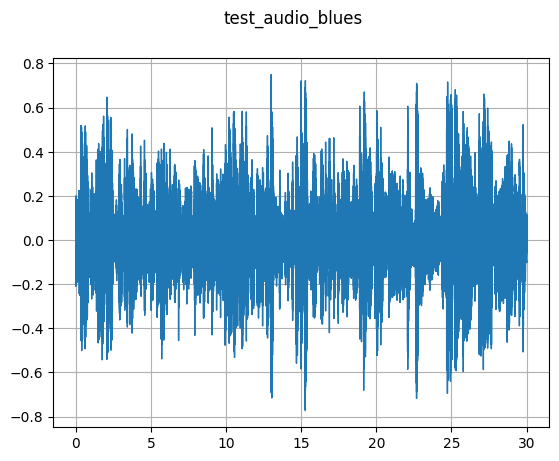

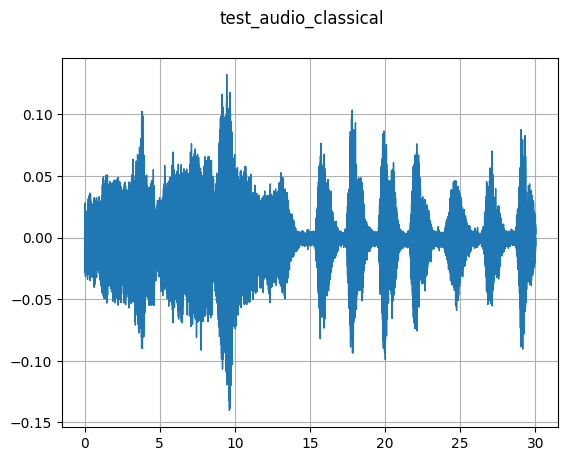

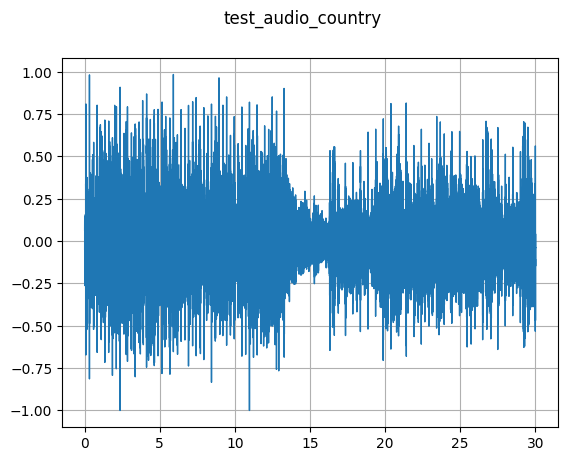

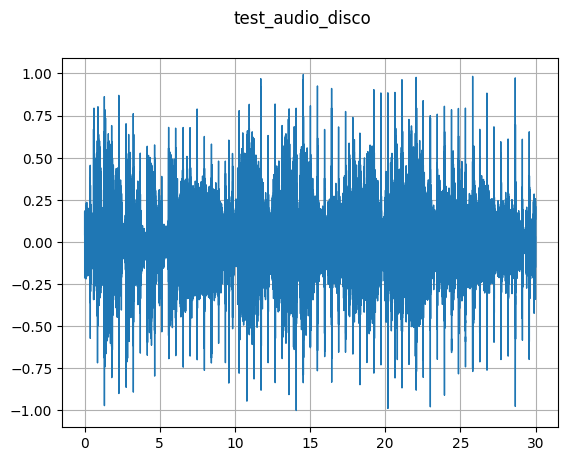

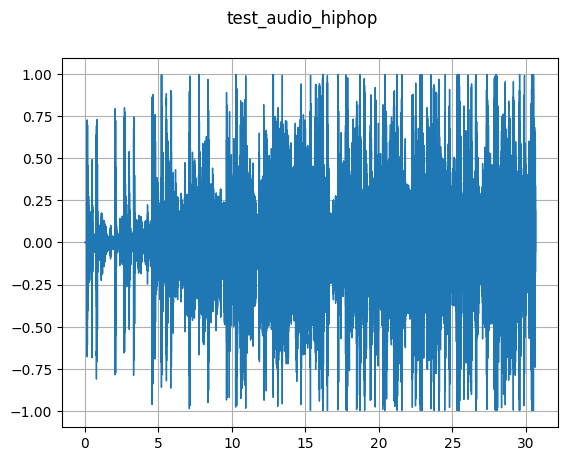

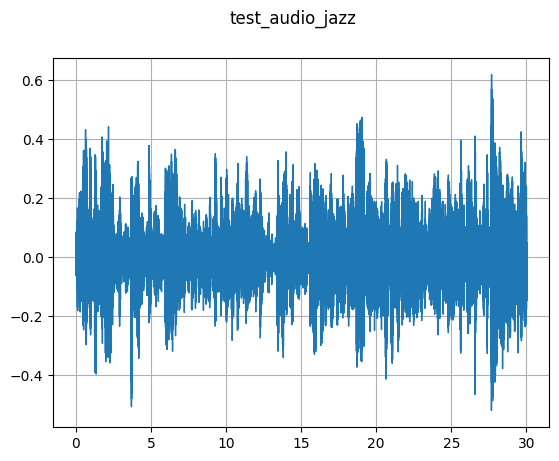

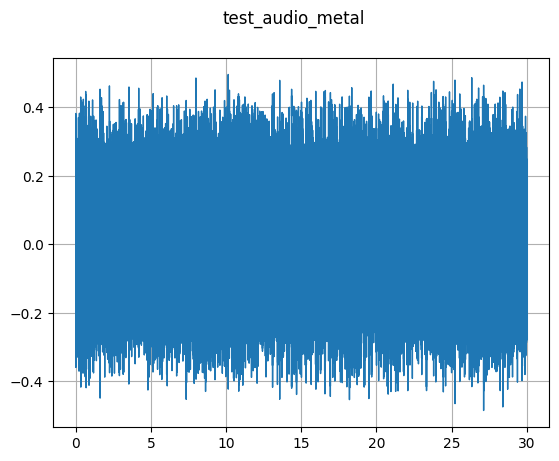

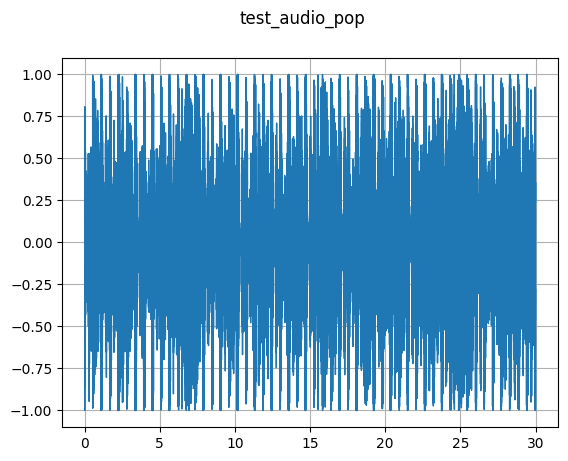

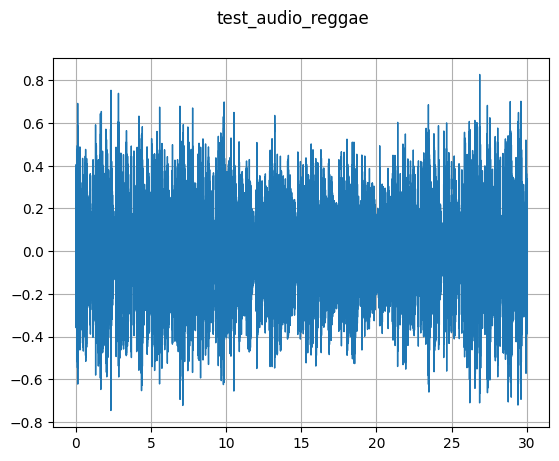

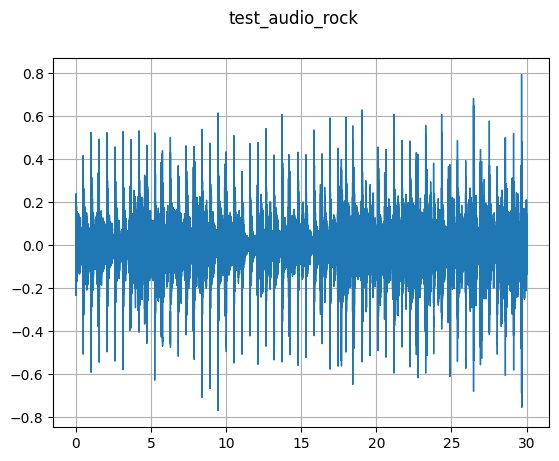

In [121]:
for audio in test_list:
    plot_waveform(audio[1], audio[2], title=str(audio[0]), xlim=None)

In [125]:
trans_list = []
for audio in test_list:
    # Define effects
    effects = [
        ["lowpass", "-1", "300"],  # apply single-pole lowpass filter
        ["speed", "0.9"],  # reduce the speed
        # This only changes sample rate, so it is necessary to
        # add `rate` effect with original sample rate after this.
        ["rate", f"{audio[2]}"],
        ["reverb", "-w"],  # Reverbration gives some dramatic feeling
    ]

    # Apply effects
    y_trans, sr_trans = torchaudio.sox_effects.apply_effects_tensor(audio[1], audio[2], effects)
    trans_list.append([audio[0] + '_trans', y_trans, sr_trans])
    print(y_trans.shape)

torch.Size([2, 817030])
torch.Size([2, 735327])
torch.Size([2, 735327])
torch.Size([2, 735004])
torch.Size([2, 750898])
torch.Size([2, 735327])
torch.Size([2, 735004])
torch.Size([2, 735004])
torch.Size([2, 735004])
torch.Size([2, 735327])


### Effects applied:




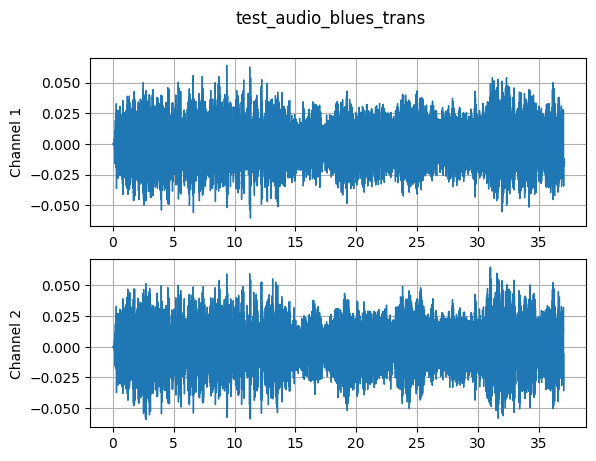

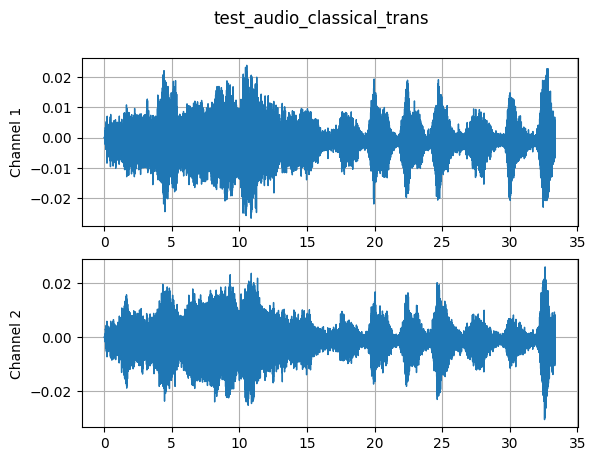

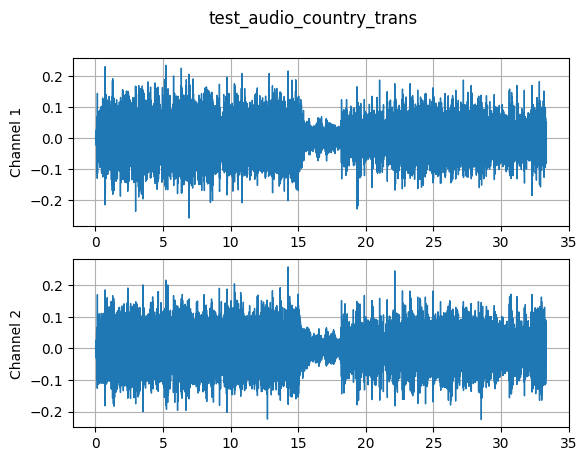

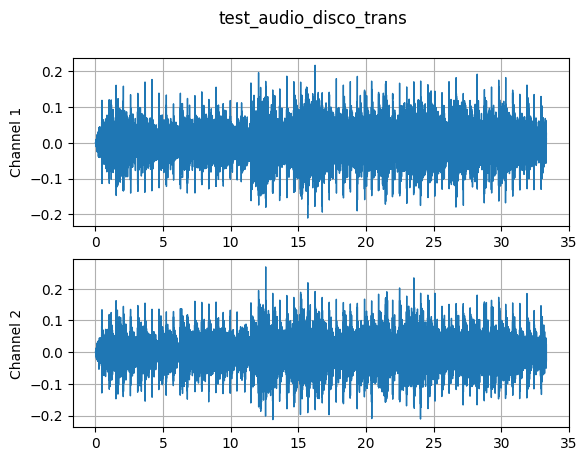

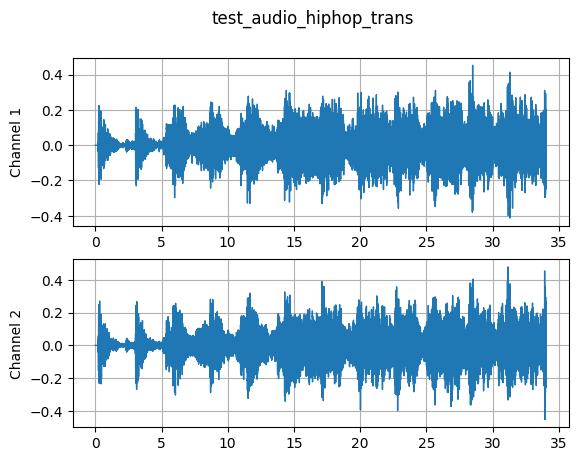

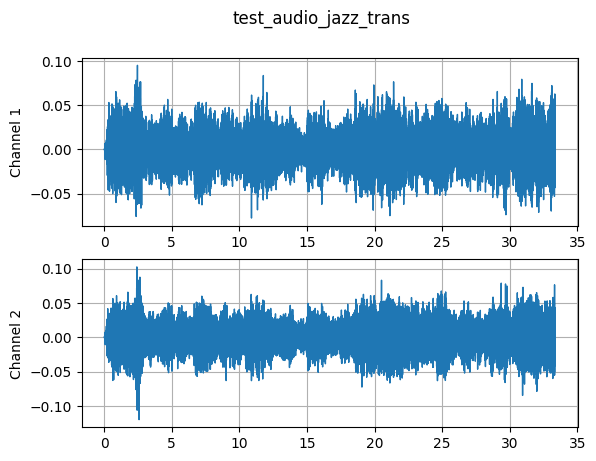

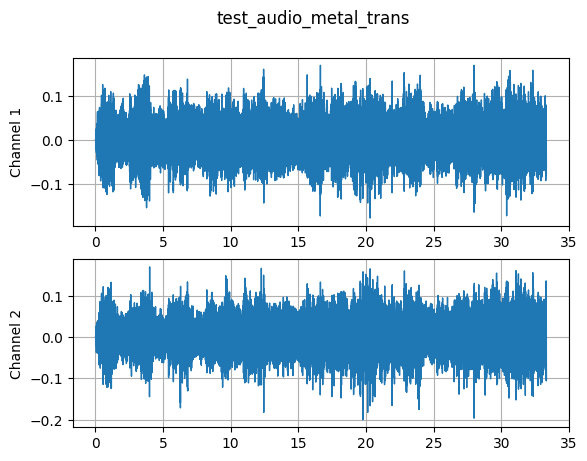

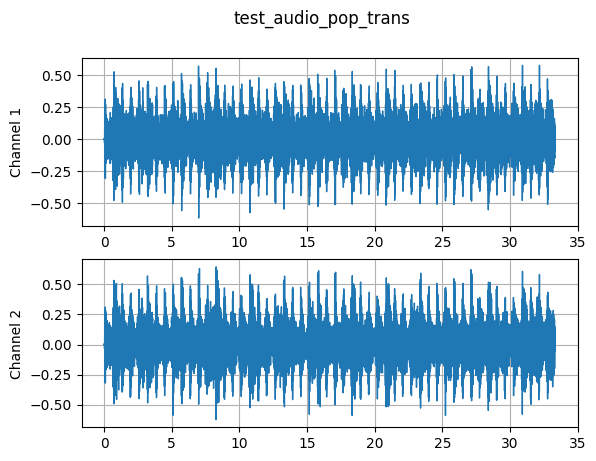

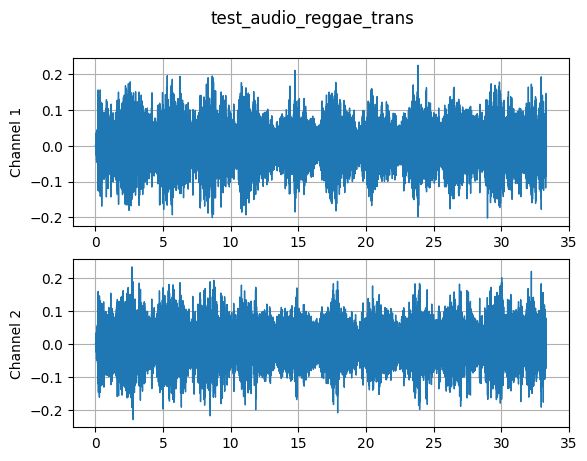

In [126]:
for audio in trans_list:
    plot_waveform(audio[1], audio[2], title=str(audio[0]), xlim=None)

In [ ]:
Audio(trans_list[0][1],trans_list[0][2])

## Simulating room reverberation

[Convolution
reverb](https://en.wikipedia.org/wiki/Convolution_reverb)_ is a
technique that's used to make clean audio sound as though it has been
produced in a different environment.

Using Room Impulse Response (RIR), for instance, we can make clean speech
sound as though it has been uttered in a conference room.

For this process, we need RIR data. The following data are from the VOiCES
dataset, but you can record your own — just turn on your microphone
and clap your hands.




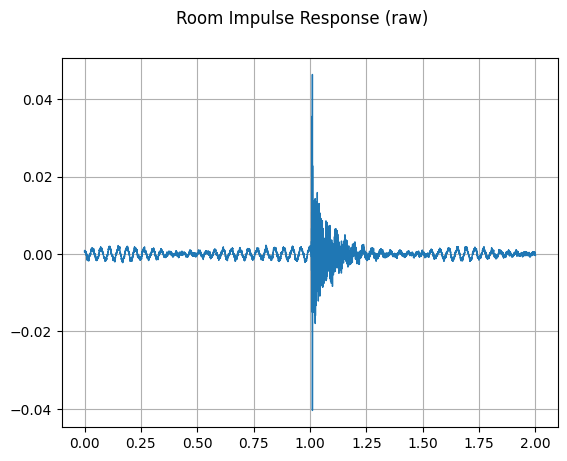

In [58]:
rir_raw, sample_rate = torchaudio.load(SAMPLE_RIR)
plot_waveform(rir_raw, sample_rate, title="Room Impulse Response (raw)")
Audio(rir_raw, rate=sample_rate)

First, we need to clean up the RIR. We extract the main impulse, normalize
the signal power, then flip along the time axis.




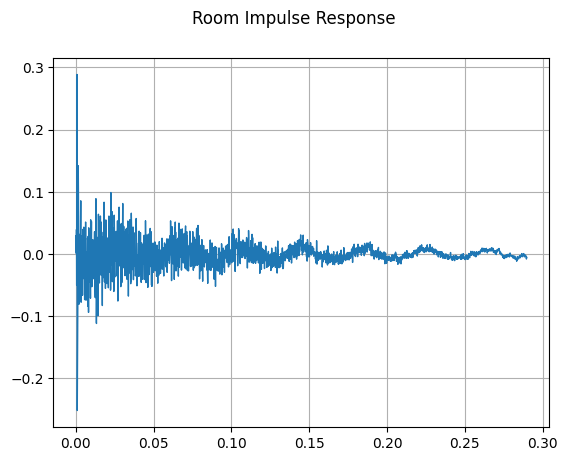

In [81]:
rir = rir_raw[:, int(sample_rate * 1.01) : int(sample_rate * 1.3)]
rir = rir / torch.norm(rir, p=2)
RIR = torch.flip(rir, [1])

plot_waveform(rir, sample_rate, title="Room Impulse Response")
Audio(rir, rate=sample_rate)

Then, we convolve the speech signal with the RIR filter.




In [60]:
speech, _ = torchaudio.load(SAMPLE_SPEECH)

speech_ = torch.nn.functional.pad(speech, (RIR.shape[1] - 1, 0))
augmented = torch.nn.functional.conv1d(speech_[None, ...], RIR[None, ...])[0]

### Original:




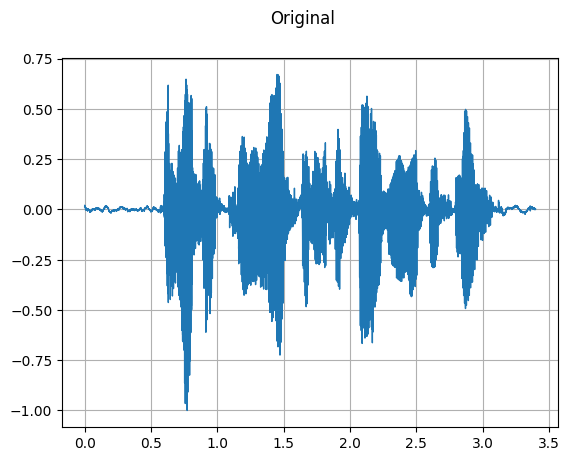

In [61]:
plot_waveform(speech, sample_rate, title="Original")
Audio(speech, rate=sample_rate)

### RIR applied:




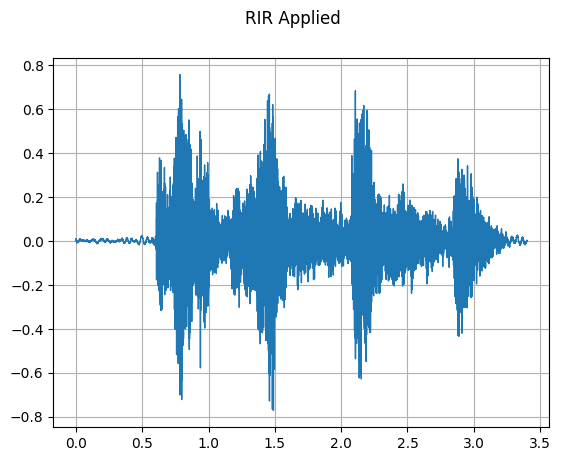

In [62]:
plot_waveform(augmented, sample_rate, title="RIR Applied")
Audio(augmented, rate=sample_rate)

## Adding background noise

To add background noise to audio data, you can simply add a noise Tensor to
the Tensor representing the audio data. A common method to adjust the
intensity of noise is changing the Signal-to-Noise Ratio (SNR).
[[wikipedia](https://en.wikipedia.org/wiki/Signal-to-noise_ratio)_]

$$ \\mathrm{SNR} = \\frac{P_{signal}}{P_{noise}} $$

$$ \\mathrm{SNR_{dB}} = 10 \\log _{{10}} \\mathrm {SNR} $$




In [63]:
speech, _ = torchaudio.load(SAMPLE_SPEECH)
noise, _ = torchaudio.load(SAMPLE_NOISE)
noise = noise[:, : speech.shape[1]]

speech_rms = speech.norm(p=2)
noise_rms = noise.norm(p=2)

snr_dbs = [20, 10, 3]
noisy_speeches = []
for snr_db in snr_dbs:
    snr = 10 ** (snr_db / 20)
    scale = snr * noise_rms / speech_rms
    noisy_speeches.append((scale * speech + noise) / 2)

### Background noise:




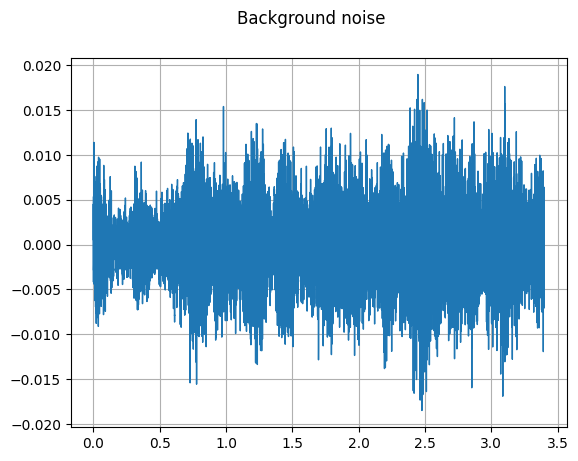

In [64]:
plot_waveform(noise, sample_rate, title="Background noise")
Audio(noise, rate=sample_rate)

### SNR 20 dB:




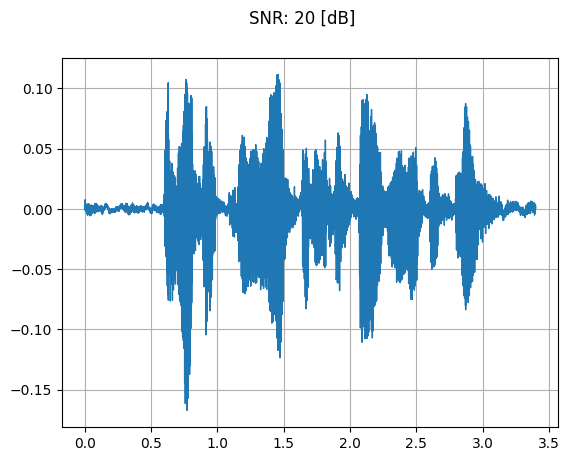

In [65]:
snr_db, noisy_speech = snr_dbs[0], noisy_speeches[0]
plot_waveform(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
Audio(noisy_speech, rate=sample_rate)

### SNR 10 dB:




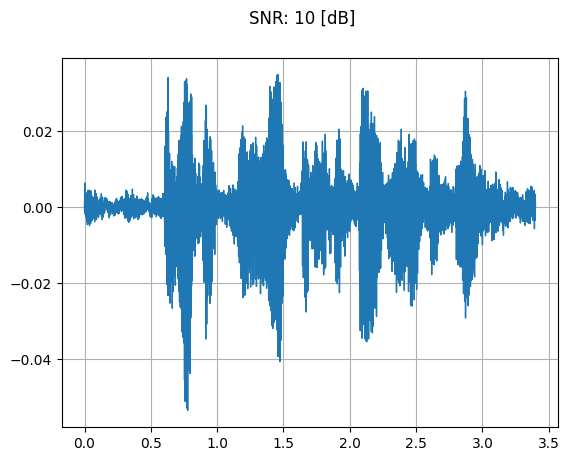

In [66]:
snr_db, noisy_speech = snr_dbs[1], noisy_speeches[1]
plot_waveform(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
Audio(noisy_speech, rate=sample_rate)

### SNR 3 dB:




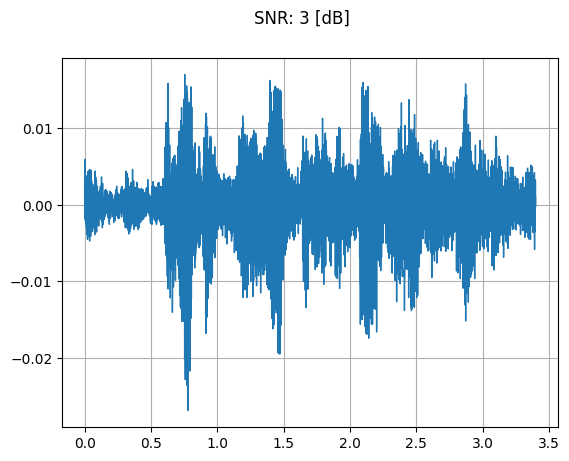

In [67]:
snr_db, noisy_speech = snr_dbs[2], noisy_speeches[2]
plot_waveform(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
Audio(noisy_speech, rate=sample_rate)

## Applying codec to Tensor object

:py:func:`torchaudio.functional.apply_codec` can apply codecs to
a Tensor object.

**Note** This process is not differentiable.




In [68]:
waveform, sample_rate = torchaudio.load(SAMPLE_SPEECH)

configs = [
    {"format": "wav", "encoding": "ULAW", "bits_per_sample": 8},
    {"format": "gsm"},
    {"format": "vorbis", "compression": -1},
]
waveforms = []
for param in configs:
    augmented = F.apply_codec(waveform, sample_rate, **param)
    waveforms.append(augmented)

formats: gsm can't encode GSM to 16-bit
formats: vorbis can't encode Vorbis to 16-bit


### Original:




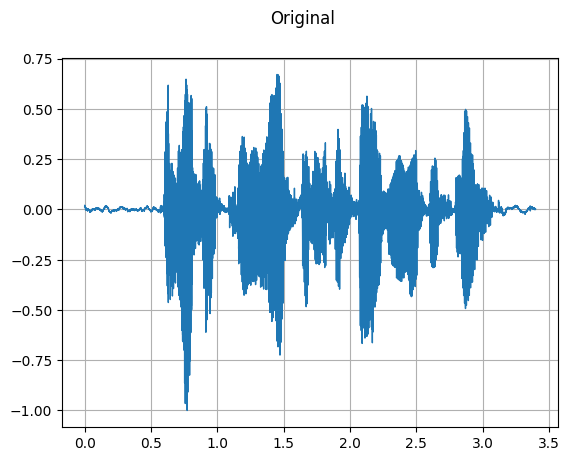

In [69]:
plot_waveform(waveform, sample_rate, title="Original")
Audio(waveform, rate=sample_rate)

## Simulating a phone recoding

Combining the previous techniques, we can simulate audio that sounds
like a person talking over a phone in a echoey room with people talking
in the background.




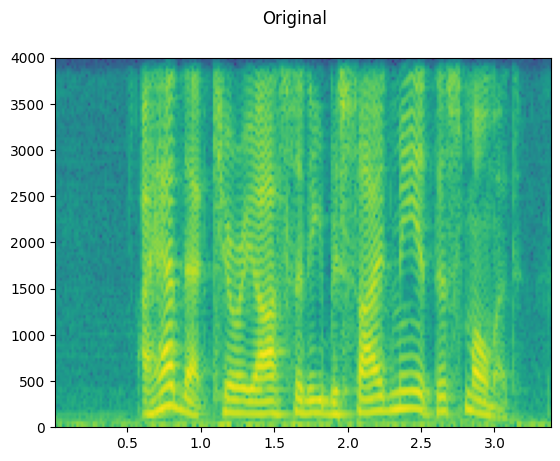

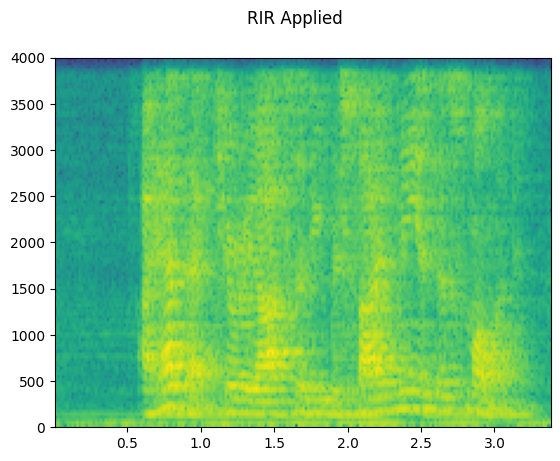

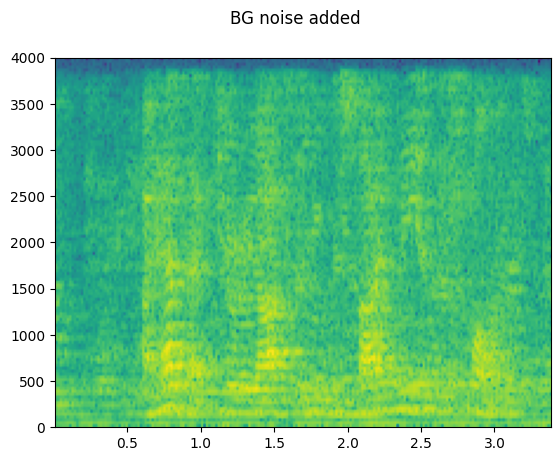

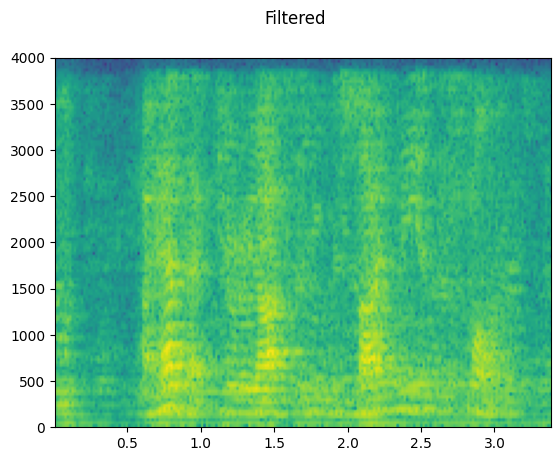

formats: gsm can't encode GSM to 16-bit


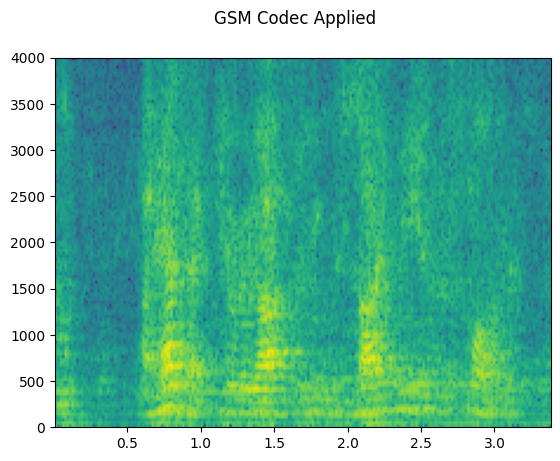

In [70]:
sample_rate = 16000
original_speech, sample_rate = torchaudio.load(SAMPLE_SPEECH)

plot_specgram(original_speech, sample_rate, title="Original")

# Apply RIR
speech_ = torch.nn.functional.pad(original_speech, (RIR.shape[1] - 1, 0))
rir_applied = torch.nn.functional.conv1d(speech_[None, ...], RIR[None, ...])[0]

plot_specgram(rir_applied, sample_rate, title="RIR Applied")

# Add background noise
# Because the noise is recorded in the actual environment, we consider that
# the noise contains the acoustic feature of the environment. Therefore, we add
# the noise after RIR application.
noise, _ = torchaudio.load(SAMPLE_NOISE)
noise = noise[:, : rir_applied.shape[1]]

snr_db = 8
scale = (10 ** (snr_db / 20)) * noise.norm(p=2) / rir_applied.norm(p=2)
bg_added = (scale * rir_applied + noise) / 2

plot_specgram(bg_added, sample_rate, title="BG noise added")

# Apply filtering and change sample rate
filtered, sample_rate2 = torchaudio.sox_effects.apply_effects_tensor(
    bg_added,
    sample_rate,
    effects=[
        ["lowpass", "4000"],
        [
            "compand",
            "0.02,0.05",
            "-60,-60,-30,-10,-20,-8,-5,-8,-2,-8",
            "-8",
            "-7",
            "0.05",
        ],
        ["rate", "8000"],
    ],
)

plot_specgram(filtered, sample_rate2, title="Filtered")

# Apply telephony codec
codec_applied = F.apply_codec(filtered, sample_rate2, format="gsm")

plot_specgram(codec_applied, sample_rate2, title="GSM Codec Applied")

### Original speech:




In [71]:
Audio(original_speech, rate=sample_rate)

### RIR applied:




In [72]:
Audio(rir_applied, rate=sample_rate)

### Background noise added:




In [73]:
Audio(bg_added, rate=sample_rate)

### Filtered:




In [74]:
Audio(filtered, rate=sample_rate2)

### Codec applied:




In [75]:
Audio(codec_applied, rate=sample_rate2)